In [ ]:
#@title Imports & Utils

!pip install -q git+https://www.github.com/google/jax-md
import jax.numpy as jnp
import numpy as onp
from jax import debug
from jax import jit
from jax import grad
from jax import random
from jax import lax
from jax.config import config

config.update('jax_enable_x64', True)
from jax_md import simulate
from jax_md import space
from jax_md import energy
from jax_md import elasticity
from jax_md import quantity
from jax_md import dataclasses
from jax_md.util import f64

# Other libraries
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from typing import Callable, Tuple, TextIO, Dict, Any, Optional, TypeVar

# LAMMPS data
!wget https://raw.githubusercontent.com/abhijeetgangan/silicon_data/main/Si_FF/Si_SW_MD/NVK_300K/lammps_nvt.dat
!wget https://raw.githubusercontent.com/abhijeetgangan/silicon_data/main/Si_FF/Si_SW_MD/NVE_300K/step_1.traj
data_lammps = pd.read_csv("lammps_nvt.dat", delim_whitespace="  ", header=None)
data_lammps = data_lammps.dropna(axis=1)
data_lammps.columns = ['Time','T','P','V','E','H']
t_l, T_l, P_l, V_l, E_l, H_l = data_lammps['Time'], data_lammps['T'], data_lammps['P'], data_lammps['V'], data_lammps['E'], data_lammps['H']

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.6/90.6 kB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 8.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 152.5/152.5 kB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 360.3/360.3 kB 10.3 MB/s eta 0:00:00
--2023-08-18 05:27:31--  https://raw.githubusercontent.com/abhijeetgangan/silicon_data/main/Si_FF/Si_SW_MD/NVK_300K/lammps_nvt.dat
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 45090 (44K) [text/plain]
Saving to: ‘lammps_nvt.dat’

lammps_nvt.dat      100%[===================>]  44.

In [ ]:
lammps_step_0 = onp.loadtxt('/content/step_1.traj', dtype=f64)
# Load positions from lammps
positions = jnp.array(lammps_step_0[:,2:5], dtype=f64)
# Load velocities from lammps
velocity = jnp.array(lammps_step_0[:,5:8], dtype=f64)
latvec = jnp.array([[21.724, 0.000000, 0.000000], [0.00000, 21.724, 0.00000],[0.00000, 0.0000, 21.724]])

In [ ]:
# Import unit system
from jax_md import units

# Metal units
unit = units.metal_unit_system()

# Simulation parameters
timestep = 1e-3
fs = timestep * unit['time']
ps = unit['time']
dt = fs
write_every = 100
box = latvec
T_init = 300 * unit['temperature']
Mass = 28.0855 * unit['mass']
key = random.PRNGKey(121)
steps = 50000

In [ ]:
# Logger to save data
log = {
'E': jnp.zeros((steps // write_every,)),
'P': jnp.zeros((steps // write_every,)),
'T': jnp.zeros((steps // write_every,)),
'kT': jnp.zeros((steps // write_every,)),
}

In [ ]:
# Setup the periodic boundary conditions.
displacement, shift = space.periodic_general(latvec)
dist_fun = space.metric(displacement)
neighbor_fn, energy_fn = energy.stillinger_weber_neighbor_list(displacement, latvec, disable_cell_list=True)
energy_fn = jit(energy_fn)

In [ ]:
# Extra capacity to prevent overflow
nbrs = neighbor_fn.allocate(positions, box=box, extra_capacity=0)

# NVK simulation
init_fn, apply_fn = simulate.nvk(energy_fn, shift, dt=dt, kT=T_init)
apply_fn = jit(apply_fn)
state = init_fn(key, positions, box=box, neighbor=nbrs, kT=T_init, mass=Mass)

# Restart from LAMMPS velocities
state = dataclasses.replace(state, momentum = Mass * velocity * unit['velocity'])

/usr/local/lib/python3.10/dist-packages/jax/_src/ops/scatter.py:93: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=int64 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "


In [ ]:
@jit
def step_fn(i, state_nbrs):
  state, nbrs = state_nbrs
  # Take a simulation step.
  t = i * dt
  state = apply_fn(state, neighbor=nbrs, kT=T_init)
  nbrs = nbrs.update(state.position, neighbor=nbrs)
  return state, nbrs

@jit
def outer_sim_fn(j, state_nbrs_log):
  state, nbrs, log = state_nbrs_log

  # Quantities to calculate
  K  = quantity.kinetic_energy(momentum = state.momentum, mass=Mass)
  E  = energy_fn(state.position, box=box, neighbor=nbrs)
  kT = quantity.temperature(momentum = state.momentum, mass=Mass)
  P  = quantity.pressure(energy_fn, state.position, box, K, neighbor=nbrs)

  # Save the quantities
  log['T'] = log['T'].at[j].set(E + K)
  log['E'] = log['E'].at[j].set(E)
  log['kT'] = log['kT'].at[j].set(kT)
  log['P'] = log['P'].at[j].set(P)

  # Print the quantities
  debug.print('Step = {j} | Total Energy = {T} | Temp = {Temp}', j=j*write_every, T = E + K, Temp=kT / unit['temperature'])

  @jit
  def inner_sim_fn(i, state_nbrs):
    return step_fn(i, state_nbrs)

  state, nbrs = lax.fori_loop(0, write_every, inner_sim_fn, (state, nbrs))

  return state, nbrs, log

In [ ]:
state_r, nbrs_r, log_r = lax.fori_loop(0, int(steps/write_every), outer_sim_fn, (state, nbrs, log))

/usr/local/lib/python3.10/dist-packages/jax/_src/ops/scatter.py:93: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=int64 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "


Step = 0 | Total Energy = -2200.4826561382038 | Temp = 299.414519001463
Step = 100 | Total Energy = -2184.1039132083733 | Temp = 299.41451900145955
Step = 200 | Total Energy = -2180.9116814130102 | Temp = 299.4145190014566
Step = 300 | Total Energy = -2178.949385566588 | Temp = 299.414519001453
Step = 400 | Total Energy = -2178.969503656968 | Temp = 299.4145190014524
Step = 500 | Total Energy = -2181.7256611643356 | Temp = 299.4145190014493
Step = 600 | Total Energy = -2182.803906191761 | Temp = 299.41451900144784
Step = 700 | Total Energy = -2180.2313257702635 | Temp = 299.41451900144364
Step = 800 | Total Energy = -2182.146945376121 | Temp = 299.41451900144233
Step = 900 | Total Energy = -2182.36259861271 | Temp = 299.4145190014395
Step = 1000 | Total Energy = -2183.021285710136 | Temp = 299.41451900143755
Step = 1100 | Total Energy = -2187.3556761366417 | Temp = 299.41451900143494
Step = 1200 | Total Energy = -2181.9494983072973 | Temp = 299.41451900143346
Step = 1300 | Total Energy

In [ ]:
# Check if neighbors overflowed
print(nbrs_r.did_buffer_overflow)

0


In [ ]:
Nsteps = int(steps/write_every)
t = jnp.arange(0, Nsteps,dtype=f64) * timestep * write_every

<ipython-input-11-5cacf784984a>:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-dark-palette')


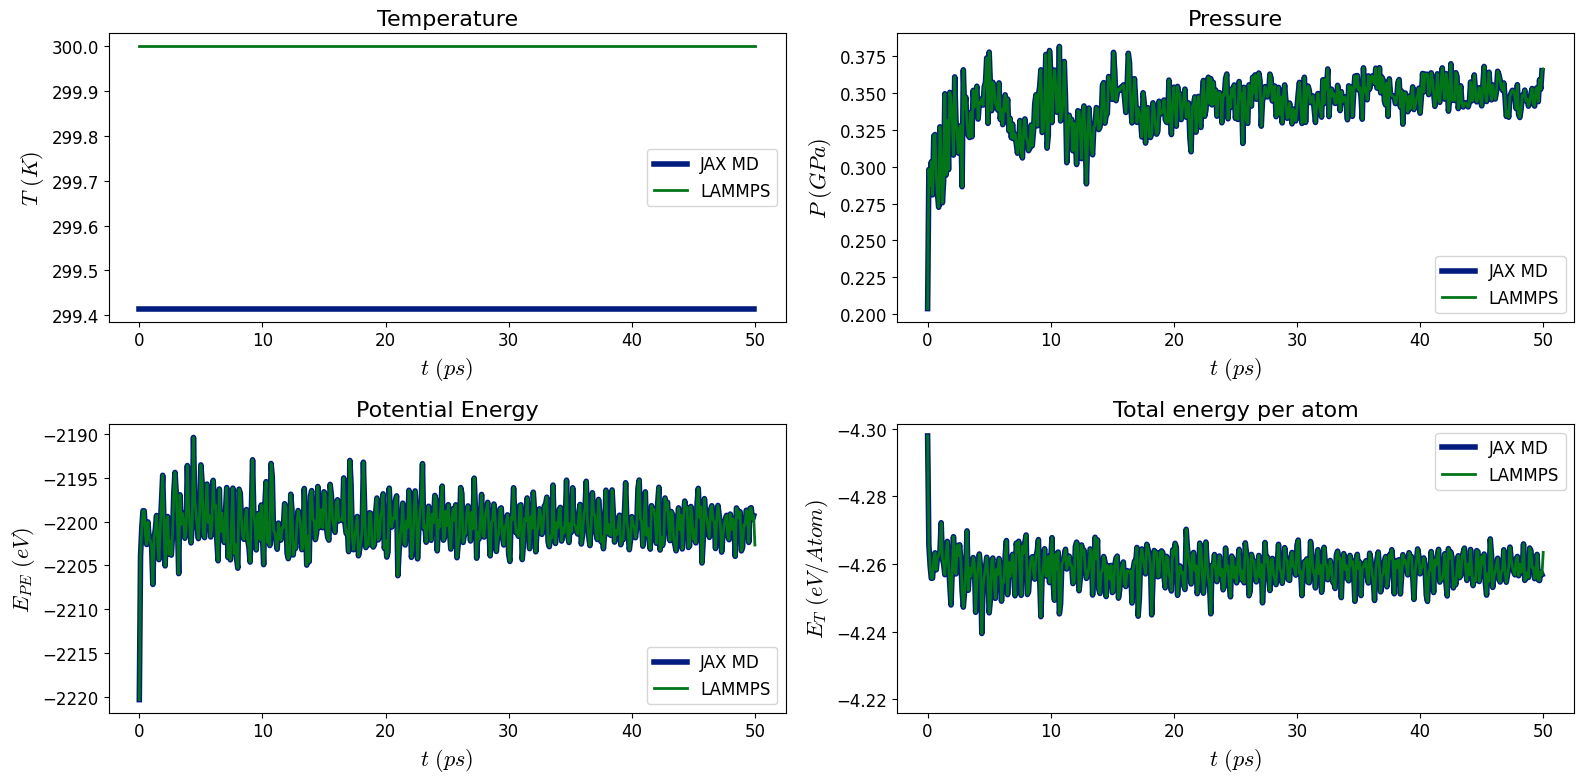

In [ ]:
plt.style.use('seaborn-dark-palette')
matplotlib.rcParams['mathtext.fontset'] = 'cm'
matplotlib.rcParams.update({'font.size': 12})
fig = plt.figure(figsize=(16, 8))

ax1 = plt.subplot(2, 2, 1)
ax1.plot(t, (log_r['kT'] / unit['temperature']), lw=4, label='JAX MD')
ax1.plot(t_l, T_l, lw=2, label='LAMMPS')
ax1.set_title('Temperature', fontsize=16)
ax1.set_ylabel("$T\ (K)$", fontsize=16)
ax1.set_xlabel("$t\ (ps)$", fontsize=16)
ax1.legend()

ax2 = plt.subplot(2, 2, 2)
ax2.plot(t, (log_r['P'] / unit['pressure']) / 10000, lw=4, label='JAX MD')
ax2.plot(t_l, P_l/10000, lw=2, label='LAMMPS')
ax2.set_title('Pressure', fontsize=16)
ax2.set_ylabel("$P\ (GPa)$", fontsize=16)
ax2.set_xlabel("$t\ (ps)$", fontsize=16)
ax2.legend()

ax3 = plt.subplot(2, 2, 3)
ax3.plot(t, log_r['E'], lw=4, label='JAX MD')
ax3.plot(t_l, E_l, lw=2, label='LAMMPS')
ax3.set_title('Potential Energy', fontsize=16)
ax3.set_ylabel("$E_{PE}\ (eV)$", fontsize=16)
ax3.set_xlabel("$t\ (ps)$", fontsize=16)
ax3.legend()

ax4 = plt.subplot(2, 2, 4)
ax4.plot(t, log_r['T']/512, lw=4, label='JAX MD')
ax4.plot(t_l, H_l/512, lw=2, label='LAMMPS')
ax4.set_title('Total energy per atom', fontsize=16)
ax4.set_ylabel("$E_{T}\ (eV/Atom)$", fontsize=16)
ax4.set_xlabel("$t\ (ps)$", fontsize=16)
ax4.set_ylim(jnp.mean(log_r['T']/512) - jnp.mean(log_r['T']/512)/100, jnp.mean(log_r['T']/512) + jnp.mean(log_r['T']/512)/100)
ax4.legend()

fig.tight_layout()